The following code reproduces Figure 2 from the manuscript, containing the following: 

Historical trends in Southern Ocean freshwater forcing, 1990-2021. (a,b) shows 1990-2021 trends in $P$-$E$ ((P-E)$_{hist}$) for the CMIP6 multi-model mean (a), and ERA5 reanalysis (b). Stippling denotes grid cells where trends are not statistically significant at the 95$\%$ level, according to a two-sided t-test, and green circles are shown as in Fig. 1a. (c) compares the magnitude of Southern Ocean-integrated $P$-$E$ trends for CMIP6 models (blue) and observations (black). Errorbars for individual models and ERA5 reanalysis indicate the standard error of the linear trend fit, while errorbars for the CMIP6 mean indicate the intermodel spread ($\pm$1$\sigma$). (d) compares the $F_{(P-E)}$ (blue) and  $F_{melt}$ (green) forcing time series and their associated uncertainties (shading), with dashed portions of the $F_{melt}$ time series indicating extrapolations from the 1994-1996 and 2015-2017 averages. Labels in (d) list the cumulative 1990-2021 freshwater input from each source.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_style='html')
import netCDF4
from scipy.stats import linregress
import os 
import dask
import cftime
import xesmf as xe

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature

import intake
from xmip.preprocessing import rename_cmip6
from xmip.preprocessing import broadcast_lonlat
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
from xmip.postprocessing import merge_variables
from xmip.postprocessing import interpolate_grid_label
from xmip.postprocessing import concat_experiments
from xmip.postprocessing import pick_first_member

%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Set root directory (replace with local path of your repo) 
root_dir = "/Users/zackkaufman/Documents/Repos/Kaufman_Freshwater_Analysis"

First, obtain 1979-2021 Southern Ocean trends in precipitation-evaporation balance (P-E) balance for 14 CMIP6 models from the google cloud. Then splice historical and projected (ssp585 emissions scenario) simulations using monthly diagnostic output for precipitation (pr) evaporation (evspsbl) from the atmosphere component (Amon) 

In [5]:

# get base query for P-E data. Four ensemble members are required to maximize coverage of desired models, 
# though two (AWI-ESM-1 and GFDL-ESM2M) still won't make it in the final set due to insufficient data. 

url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
col = intake.open_esm_datastore(url)

df_base = col.search(
    activity_id=['CMIP','ScenarioMIP'],
    table_id = ['Amon'],
    variable_id = ['pr','evspsbl'],
    experiment_id = ['historical','ssp585'],
    source_id = [
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "AWI-ESM-1-REcoM",
    "CanESM5",
    "CAS-ESM2-0",
    "CESM2",
    "FGOALS-g3",
    "GFDL-CM4",
    "GFDL-ESM2M",
    "GFDL-ESM4",
    "GISS-E2-1-G",
    "HadGEM3-GC31-LL",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0"
],
    member_id = ['r1i1p1f1','r1i1p1f3','r1i1p5f1','r10i1p1f1']

)

# create xarray dictionaries for each search query 
kwargs = {
    'zarr_kwargs':{
        'use_cftime':True
    },
    'aggregate':False,
    
    'preprocess':combined_preprocessing
}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    combined_dict = df_base.to_dataset_dict(**kwargs)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [6]:
# merge pr and evspsbl variables together in each dataset 
combined_dict_merged = merge_variables(combined_dict)

# subset to the time period of interest 

historical_start = '1979-01-01'
historical_end = '2014-12-30'
ssp585_start = '2015-01-01'
ssp585_end = '2021-12-30'

# Adjust time range for historical and ssp585 data in the original dictionary
for key, value in combined_dict_merged.items():
    # Check if the item is related to historical data
    if 'historical' in key:
        combined_dict_merged[key] = value.sel(time=slice(historical_start, historical_end))
    # Check if the item is related to ssp245 data
    elif 'ssp585' in key:
        combined_dict_merged[key] = value.sel(time=slice(ssp585_start, ssp585_end))
        
# splice the experiments together 
PE_dict_CMIP6 = concat_experiments(combined_dict_merged)

# get rid of unneeded models and verify we have 14 
del PE_dict_CMIP6['GISS-E2-1-G.gn.Amon.r1i1p1f1']
del PE_dict_CMIP6['CESM2.gn.Amon.r1i1p1f1']
del PE_dict_CMIP6['GISS-E2-1-G.gn.Amon.r1i1p1f3']
del PE_dict_CMIP6['GISS-E2-1-G.gn.Amon.r10i1p1f1']
del PE_dict_CMIP6['ACCESS-ESM1-5.gn.Amon.r10i1p1f1']
del PE_dict_CMIP6['MPI-ESM1-2-LR.gn.Amon.r10i1p1f1']
del PE_dict_CMIP6['MIROC6.gn.Amon.r10i1p1f1']
del PE_dict_CMIP6['CanESM5.gn.Amon.r10i1p1f1']
del PE_dict_CMIP6['MPI-ESM1-2-HR.gn.Amon.r10i1p1f1']
del PE_dict_CMIP6['MRI-ESM2-0.gn.Amon.r10i1p1f1']
print("Number of items in the combined dictionary:", len(PE_dict_CMIP6))
list(PE_dict_CMIP6.keys())


Number of items in the combined dictionary: 14


['CESM2.gn.Amon.r10i1p1f1',
 'FGOALS-g3.gn.Amon.r1i1p1f1',
 'CAS-ESM2-0.gn.Amon.r1i1p1f1',
 'HadGEM3-GC31-LL.gn.Amon.r1i1p1f3',
 'CanESM5.gn.Amon.r1i1p1f1',
 'MPI-ESM1-2-HR.gn.Amon.r1i1p1f1',
 'GFDL-CM4.gr1.Amon.r1i1p1f1',
 'GFDL-ESM4.gr1.Amon.r1i1p1f1',
 'ACCESS-CM2.gn.Amon.r1i1p1f1',
 'MPI-ESM1-2-LR.gn.Amon.r1i1p1f1',
 'MIROC6.gn.Amon.r1i1p1f1',
 'MRI-ESM2-0.gn.Amon.r1i1p1f1',
 'ACCESS-ESM1-5.gn.Amon.r1i1p1f1',
 'GISS-E2-1-G.gn.Amon.r1i1p5f1']

In [5]:
%%time 
# To show a map of the CMIP6 ensemble mean P-E trends, we need
# the P-E data on a standard 1x1 grid using XESMF regridder 

def regrid_dataarray(dataset,data):
    ds_out = xe.util.grid_global(1,1)
    regridder = xe.Regridder(dataset,ds_out, 'bilinear',periodic=True,\
    ignore_degenerate=True)
    return regridder(data)

PE_dict_CMIP6_regridded = {}
for key in list(PE_dict_CMIP6.keys()):
    pr = PE_dict_CMIP6[key].pr.squeeze()
    evspsbl = PE_dict_CMIP6[key].evspsbl.squeeze() 
    PE  = pr - evspsbl
    PE_dict_CMIP6_regridded[key] = regrid_dataarray(PE_dict_CMIP6[key],PE).load()

# we also want to standardize the calendars across both the regridded and original dictionaries. 

calendar_standard = PE_dict_CMIP6['ACCESS-ESM1-5.gn.Amon.r1i1p1f1']['time'].values

for key in list(PE_dict_CMIP6.keys()):
    PE_dict_CMIP6[key]['time'] = calendar_standard 
    PE_dict_CMIP6_regridded[key]['time'] = calendar_standard 

CPU times: user 1min 51s, sys: 24.4 s, total: 2min 15s
Wall time: 3min 16s


In [6]:
%%time 
# Now we calculate P-E trends in each grid cell for the CMIP6 multi-model mean (MMM)
# first convert the dictionary to an xarray dataset with a "model" dimension so that we can take the model mean. 

dummy_list = [] 
for key in list(PE_dict_CMIP6.keys()):
    dummy_list.append(PE_dict_CMIP6_regridded[key])
    
PE_CMIP6_regridded_MMM = xr.concat(dummy_list, dim='model').mean(dim='model')

# Then, store linear regression coefficients and p-values for the annual mean time series in each cell 
# we'll subset to the Southern Hemisphere extratropics for efficiency 

def subset_bylatitude(data, south_bound, north_bound):
    lat_mask = (data.lat >= south_bound) & (data.lat <= north_bound)
    data_SO = data.where(lat_mask, drop=True)
    return data_SO

PE_CMIP6_regridded_MMM_subset = \
subset_bylatitude(PE_CMIP6_regridded_MMM,-90,-30).sel(time=slice('1990','2021')).groupby('time.year').mean()  

time = np.linspace(1990,2021,32)
regression_coefficients_MMM = PE_CMIP6_regridded_MMM_subset[0,:,:].drop_vars('year').copy()
p_values_MMM = PE_CMIP6_regridded_MMM_subset[0,:,:].drop_vars('year').copy()
    
for lat in PE_CMIP6_regridded_MMM_subset.y:
    for lon in PE_CMIP6_regridded_MMM_subset.x:
        data_slice = PE_CMIP6_regridded_MMM_subset.sel(y=lat, x=lon)
            
        # Skip grid cells where the input values are 0 or nan at all timesteps
        if np.all(np.isnan(data_slice)) or np.all(data_slice == 0):
            continue

        # Calculate regression coefficients and p-values
        slope, intercept, r_value, p_value, std_err = linregress(time, data_slice)

        regression_coefficients_MMM.loc[dict(y=lat, x=lon)] = slope
        p_values_MMM.loc[dict(y=lat, x=lon)] = p_value
    
linear_regression_results_CMIP6_MMM = {}
linear_regression_results_CMIP6_MMM['MMM_coefs'] = regression_coefficients_MMM
linear_regression_results_CMIP6_MMM['MMM_p_values'] = p_values_MMM


CPU times: user 1min 5s, sys: 3.78 s, total: 1min 9s
Wall time: 1min 10s


In [7]:
# the analagous regression maps for ERA5 observations have been pre-processed in the same manner as CMIP6
# but using the higher-resolution ERA5 native grid. 

data_path = os.path.join(root_dir,"Source_Data/ERA5_PE_trendmaps")
os.chdir(data_path)
ERA5_PE_trendmap_coefs = xr.open_dataset('ERA5_PE_trendmap_coefs.nc').__xarray_dataarray_variable__
ERA5_PE_trendmap_pvals = xr.open_dataset('ERA5_PE_trendmap_pvals.nc').__xarray_dataarray_variable__

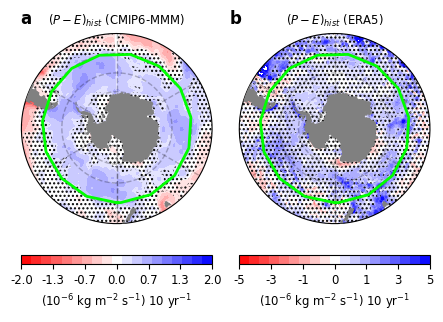

CPU times: user 30.7 s, sys: 452 ms, total: 31.1 s
Wall time: 31.7 s


In [8]:
%%time
# Plot Fig. 2a,b
########################################################################
# define parameters for each map subplot
cbarmin_plot1 = -2
cbarmax_plot1 = 2
cbarlabel_plot1 = r'(10$^{-6}$ kg m$^{-2}$ s$^{-1}$) 10 yr$^{-1}$'
cmap_plot1 = 'bwr_r'  
levels_plot1 = np.linspace(cbarmin_plot1, cbarmax_plot1, 20)
ticks_plot1 = np.linspace(cbarmin_plot1, cbarmax_plot1, 7)

cbarmin_plot2 = -5
cbarmax_plot2 = 5
cbarlabel_plot2 = r'(10$^{-6}$ kg m$^{-2}$ s$^{-1}$) 10 yr$^{-1}$'
cmap_plot2 = 'bwr_r'  
levels_plot2 = np.linspace(cbarmin_plot2, cbarmax_plot2, 20)
ticks_plot2 = np.linspace(cbarmin_plot2, cbarmax_plot2, 7)


significance_threshold = 0.05
########################################################################
# define plot 
fig, axs = plt.subplots(1,2, figsize=(4.32, 4.32),
                        subplot_kw=dict(projection=ccrs.SouthPolarStereo()),
                        layout='compressed')
########################################################################
# Iterate over each row in the grid
for ax in axs:
    # Set basemap parameters for the current axis
    ax.set_extent([-180, 180, -89, -40], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, zorder=300, facecolor='gray')
    ax.add_feature(cartopy.feature.COASTLINE, zorder=300, edgecolor='none')

    # Add latitude circles in 10-degree intervals
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, color='black', linestyle='--',zorder=303,alpha=.25)
    gl.ylocator = mticker.FixedLocator(np.arange(-90, -19, 10))

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
########################################################################
# Plot the data for CMIP6 
data = linear_regression_results_CMIP6_MMM['MMM_coefs']  
FW_plot1 = \
axs[0].contourf(data.lon, data.lat, data*1e7,
                       transform=ccrs.PlateCarree(), levels=levels_plot1, cmap=cmap_plot1)
p_values = linear_regression_results_CMIP6_MMM['MMM_p_values']
significant_data = np.ma.masked_where(p_values < significance_threshold, data)
axs[0].contourf(data.lon, data.lat, significant_data,
            transform=ccrs.PlateCarree(), levels=[-0.5, 0.5], hatches=['....'], alpha=0)
########################################################################
# plot the data for ERA5 
data = ERA5_PE_trendmap_coefs  
FW_plot2 = \
axs[1].contourf(data.lon, data.lat, data*1e7,
                       transform=ccrs.PlateCarree(), levels=levels_plot2, cmap=cmap_plot2)

p_values = ERA5_PE_trendmap_pvals
significant_data = np.ma.masked_where(p_values < significance_threshold, data)
axs[1].contourf(data.lon, data.lat, significant_data,
            transform=ccrs.PlateCarree(), levels=[-0.5, 0.5], hatches=['....'], alpha=0)
########################################################################
# add spatial integral domain lines 
axs[0].plot([-180, 180], [-50, -50], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)
axs[1].plot([-180, 180], [-50, -50], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)
########################################################################
# create titles for each subplot
axs[0].set_title(r'$(P-E)_{hist}$ (CMIP6-MMM)', fontsize='small')
axs[0].text(-1.15, 1.05, "a", transform=ax.transAxes, fontsize='large', fontweight='bold')
axs[1].set_title(r'$(P-E)_{hist}$ (ERA5)', fontsize='small')
axs[1].text(-0.05, 1.05, "b", transform=ax.transAxes, fontsize='large', fontweight='bold')
########################################################################
# Create colorbars for each subplot
cbar1 = fig.colorbar(FW_plot1, ax=axs[0],ticks=ticks_plot1, location='bottom',format='%.1f')
cbar1.ax.tick_params(labelsize='small')
cbar1.set_label(cbarlabel_plot1,fontsize='small')

cbar2 = fig.colorbar(FW_plot2, ax=axs[1], ticks=ticks_plot2, location='bottom', format="%d")
cbar2.ax.tick_params(labelsize='small')
cbar2.set_label(cbarlabel_plot2,fontsize='small')
########################################################################
# show the plot 
plt.show()

In [8]:
# Now we will obtain the spatially averaged P-E time series, which requires land mask and cell areas for the CMIP6 grids. 
# we'll start with cell area 

df_area = col.search(
    table_id = ['fx'],
    variable_id = ['areacella'],
    grid_label = ['gn','gr1'],
    experiment_id = ['piControl'],
    source_id = [
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "AWI-ESM-1-REcoM",
    "CanESM5",
    "CAS-ESM2-0",
    "CESM2",
    "FGOALS-g3",
    "GFDL-CM4",
    "GFDL-ESM2M",
    "GFDL-ESM4",
    "GISS-E2-1-G",
    "HadGEM3-GC31-LL",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0"
]
)

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    areacella_dict = pick_first_member(df_area.to_dataset_dict(**kwargs))
print("Number of items in the combined dictionary:", len(areacella_dict))
list(areacella_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Number of items in the combined dictionary: 12


['CESM2.gn.piControl.fx.areacella',
 'GFDL-ESM4.gr1.piControl.fx.areacella',
 'MIROC6.gn.piControl.fx.areacella',
 'GISS-E2-1-G.gn.piControl.fx.areacella',
 'MRI-ESM2-0.gn.piControl.fx.areacella',
 'HadGEM3-GC31-LL.gn.piControl.fx.areacella',
 'CanESM5.gn.piControl.fx.areacella',
 'MPI-ESM1-2-HR.gn.piControl.fx.areacella',
 'MPI-ESM1-2-LR.gn.piControl.fx.areacella',
 'ACCESS-CM2.gn.piControl.fx.areacella',
 'ACCESS-ESM1-5.gn.piControl.fx.areacella',
 'GFDL-CM4.gr1.piControl.fx.areacella']

In [9]:
# And now land frac 

df_area = col.search(
    table_id = ['fx'],
    variable_id = ['sftlf'],
    grid_label = ['gn','gr1'],
    experiment_id = ['piControl'],
    source_id = [
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "AWI-ESM-1-REcoM",
    "CanESM5",
    "CAS-ESM2-0",
    "CESM2",
    "FGOALS-g3",
    "GFDL-CM4",
    "GFDL-ESM2M",
    "GFDL-ESM4",
    "GISS-E2-1-G",
    "HadGEM3-GC31-LL",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0"
]
)

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sftlf_dict = pick_first_member(df_area.to_dataset_dict(**kwargs))
print("Number of items in the combined dictionary:", len(sftlf_dict))
list(sftlf_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Number of items in the combined dictionary: 12


['ACCESS-ESM1-5.gn.piControl.fx.sftlf',
 'CanESM5.gn.piControl.fx.sftlf',
 'HadGEM3-GC31-LL.gn.piControl.fx.sftlf',
 'MRI-ESM2-0.gn.piControl.fx.sftlf',
 'GISS-E2-1-G.gn.piControl.fx.sftlf',
 'ACCESS-CM2.gn.piControl.fx.sftlf',
 'GFDL-CM4.gr1.piControl.fx.sftlf',
 'MPI-ESM1-2-LR.gn.piControl.fx.sftlf',
 'CESM2.gn.piControl.fx.sftlf',
 'FGOALS-g3.gn.piControl.fx.sftlf',
 'MPI-ESM1-2-HR.gn.piControl.fx.sftlf',
 'MIROC6.gn.piControl.fx.sftlf']

In [10]:
#  merge these coordinates into our pre-existing CMIP6 dictionary 

PE_dict_CMIP6 = \
match_metrics(PE_dict_CMIP6, areacella_dict, ['areacella'], match_attrs=['source_id', 'grid_label'])
PE_dict_CMIP6 = \
match_metrics(PE_dict_CMIP6, sftlf_dict, ['sftlf'], match_attrs=['source_id', 'grid_label'])


# regrid the three mdoels missing above variables to arbitrary reference grid (ACCESS model) 

def regrid_dataarray_v2(in_grid,out_grid):
    regridder = xe.Regridder(in_grid,out_grid, 'bilinear', periodic=True, ignore_degenerate=True)
    regridded = regridder(in_grid)
    return regridded

PE_dict_CMIP6['FGOALS-g3.gn.Amon.r1i1p1f1'] = regrid_dataarray_v2\
(PE_dict_CMIP6['FGOALS-g3.gn.Amon.r1i1p1f1'],PE_dict_CMIP6['ACCESS-ESM1-5.gn.Amon.r1i1p1f1'])
PE_dict_CMIP6['CAS-ESM2-0.gn.Amon.r1i1p1f1'] = regrid_dataarray_v2\
(PE_dict_CMIP6['CAS-ESM2-0.gn.Amon.r1i1p1f1'],PE_dict_CMIP6['ACCESS-ESM1-5.gn.Amon.r1i1p1f1'])
PE_dict_CMIP6['GFDL-ESM4.gr1.Amon.r1i1p1f1'] = regrid_dataarray_v2\
(PE_dict_CMIP6['GFDL-ESM4.gr1.Amon.r1i1p1f1'],PE_dict_CMIP6['ACCESS-ESM1-5.gn.Amon.r1i1p1f1'])


# clean up to avoid member_id conflicts in the merged area coordinates

def update_PE_dict(PE_dict, areacella_dict, sftlf_dict, model_key, area_key, sftlf_key):
    PE_dict[model_key]['areacella'] = areacella_dict[area_key].areacella.squeeze()
    PE_dict[model_key]['sftlf'] = sftlf_dict[sftlf_key].sftlf.squeeze()

update_PE_dict(PE_dict_CMIP6, areacella_dict, sftlf_dict, \
               'CESM2.gn.Amon.r10i1p1f1', 'CESM2.gn.piControl.fx.areacella', 'CESM2.gn.piControl.fx.sftlf')

update_PE_dict(PE_dict_CMIP6, areacella_dict, sftlf_dict, 
               'HadGEM3-GC31-LL.gn.Amon.r1i1p1f3', 'HadGEM3-GC31-LL.gn.piControl.fx.areacella', 'HadGEM3-GC31-LL.gn.piControl.fx.sftlf')

update_PE_dict(PE_dict_CMIP6, areacella_dict, sftlf_dict, 
               'GISS-E2-1-G.gn.Amon.r1i1p5f1', 'GISS-E2-1-G.gn.piControl.fx.areacella', 'GISS-E2-1-G.gn.piControl.fx.sftlf')

update_PE_dict(PE_dict_CMIP6, areacella_dict, sftlf_dict, 
               'FGOALS-g3.gn.Amon.r1i1p1f1', 'ACCESS-ESM1-5.gn.piControl.fx.areacella', 'ACCESS-ESM1-5.gn.piControl.fx.sftlf')

update_PE_dict(PE_dict_CMIP6, areacella_dict, sftlf_dict, 
               'CAS-ESM2-0.gn.Amon.r1i1p1f1', 'ACCESS-ESM1-5.gn.piControl.fx.areacella', 'ACCESS-ESM1-5.gn.piControl.fx.sftlf')

update_PE_dict(PE_dict_CMIP6, areacella_dict, sftlf_dict, 
               'GFDL-ESM4.gr1.Amon.r1i1p1f1', 'ACCESS-ESM1-5.gn.piControl.fx.areacella', 'ACCESS-ESM1-5.gn.piControl.fx.sftlf')

In [12]:
%%time
# now we can integrate over the domain shown in Fig.2a,b to produce annual mean time series in Gt yr^-1 
# we mask out land so only P-E over the ocean is considered. 

for key in list(PE_dict_CMIP6.keys()):
    PE_dict_CMIP6[key]['areacella'] = PE_dict_CMIP6[key]['areacella'].where(PE_dict_CMIP6[key]['sftlf']==0,np.nan)
    

def subset_bylatitude(data, south_bound, north_bound):
    data_SO = data.sel(y=slice(south_bound, north_bound))
    return data_SO

unit_conversion = (1e-12) * (np.pi * 1e7)  # kg/s to Gt/yr
xaxis_time = np.linspace(1990, 2021, 32)
PE_CMIP_timeseries = {}


for key, ds in PE_dict_CMIP6.items():
    # Extract vars
    pr = ds.pr.squeeze()
    evspsbl = ds.evspsbl.squeeze()
    areacella = ds.areacella.squeeze()

    # Calculate P-E for each grid cell
    PE = pr - evspsbl

    # Regrid, integrate over the Southern Ocean, and convert to Gt/yr
    PE_SO_sum = \
    (subset_bylatitude(PE, -90, -50) * subset_bylatitude(areacella, -90, -50)).sum(dim=('x', 'y')) * unit_conversion

    # Calculate anomalies relative to the 1979-1989 baseline
    PE_SO_anoms = \
    PE_SO_sum.sel(time=slice('1990', '2021')) - PE_SO_sum.sel(time=slice('1979', '1989')).mean(dim='time')

    # Save the time series to the dictionary
    PE_CMIP_timeseries[key] = PE_SO_anoms.coarsen(time=12).mean().compute()

CPU times: user 41.3 s, sys: 17.3 s, total: 58.7 s
Wall time: 1min 45s


In [13]:
# the analagous spatially averaged time series for ERA5 observations has been pre-processed in the same manner as CMIP6
# It also had to be regridded to the arbitrary reference grid due to unavailable landmask/areacell data. 
# file contains monthly averages 

data_path = os.path.join(root_dir,"Source_Data")
os.chdir(data_path)
ERA5_PE_timeseries = xr.open_dataset('ERA5_PE_timeseries_monthly.nc').__xarray_dataarray_variable__

# Calculate anomalies relative to the 1979-1989 baseline
PE_SO_anoms_obs = \
ERA5_PE_timeseries.sel(time=slice('1990', '2021')) - ERA5_PE_timeseries.sel(time=slice('1979', '1989')).mean(dim='time')

PE_SO_anoms_obs = PE_SO_anoms_obs.coarsen(time=12).mean()

In [42]:
# Plot Fig. 2c (OLD VERSION) 

#groups = list(PE_CMIP_timeseries.keys())

# Initialize the figure with specific dimensions
#plt.figure(figsize=(6.32, 2.16))

#plt.plot(xaxis_time, PE_SO_anoms_obs.values, color='k', label=r'$(P-E)_{hist}$ (ERA5)')

# Compute the average of blue curves
#sum_of_curves = xr.zeros_like(PE_CMIP_timeseries[groups[0]])  # Initialize with the same shape and type
#for group in groups:
#    plt.plot(xaxis_time, PE_CMIP_timeseries[group].values, color='b', alpha=0.2)
#    sum_of_curves += PE_CMIP_timeseries[group].values

#average_of_blue_curves = sum_of_curves / len(groups)
#plt.plot(xaxis_time, average_of_blue_curves, color='b', label=r'$(P-E)_{hist}$ (CMIP6)')

# Fit and plot linear trend line for the black curve
#slope_obs, intercept, r_value, p_value, std_err_obs = linregress(xaxis_time, PE_SO_anoms_obs.values)
#trend_label_obs = f'{slope_obs:.2f} Gt yr$^{{-2}}$'
#plt.plot(xaxis_time, intercept + slope_obs * xaxis_time, color='k', linestyle='--', label=trend_label_obs)

# Fit and plot linear trend line for the average of blue curves
#slope_avg, intercept_avg, r_value_avg, p_value_avg, std_err_avg = linregress(xaxis_time, average_of_blue_curves)
#trend_label_avg = f'{slope_avg:.2f} Gt yr$^{{-2}}$'
#plt.plot(xaxis_time, intercept_avg + slope_avg * xaxis_time, color='b', linestyle='--', label=trend_label_avg)

# Add labels, legend, etc.
#plt.xlabel('Time (Years)')
#plt.ylabel(r'Anomaly (Gt yr$^{-1}$)')
#plt.title(r'Historical (P-E) Anomalies')
#plt.text(0.01, 1.25, 'c', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', va='top')


# Adjust y-axis ticks
#ax = plt.gca()
#ax.yaxis.set_major_locator(ticker.AutoLocator())

# Place the legend outside the plot
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
#plt.tight_layout()

#plt.show()

In [15]:
# Now let's get statistics on the trends from Fig. 2c to use in Fig. 2d (current notebook) and Fig. 3 (future notebook)

slopes_CMIP6 = []
std_errs_CMIP6 = [] 

# Calculate the slope for each time series
for key in PE_CMIP_timeseries:
    slope, _, _, _, std_err = linregress(xaxis_time, PE_CMIP_timeseries[key].values)
    slopes_CMIP6.append(slope)
    std_errs_CMIP6.append(std_err)

# do the Same for ERA5
slope_obs, intercept, r_value, p_value, std_err_obs = linregress(xaxis_time, PE_SO_anoms_obs.values)


# Compute the mean and standard deviation of the CMIP6 slopes (we already have ERA5 obs. from previous cell) 
avg_slopes_CMIP6 = np.mean(slopes_CMIP6) 
std_dev_slopes_CMIP6 = np.std(slopes_CMIP6)

# calculate F_PE as the difference between CMIP6 and ERA5 and combine uncertainties in quadrature 
F_PE = slope_obs - avg_slopes_CMIP6 
error_F_PE = np.sqrt((std_dev_slopes_CMIP6**2)+(std_err_obs**2))


print('CMIP6 mean P-E trend: ',avg_slopes_CMIP6)
print('CMIP6 spread P-E trend: ',std_dev_slopes_CMIP6)
print('---------')
print('ERA5 P-E trend: ',slope_obs)
print('ERA5 error P-E trend: ',std_err_obs)
print('ERA5 p-value P-E trend: ',p_value)
print('---------')
print(f'F$_{{(P-E)}}$ trend: ',F_PE)
print(f'F$_{{(P-E)}}$ uncertainty: ',error_F_PE)

CMIP6 mean P-E trend:  46.968351594932074
CMIP6 spread P-E trend:  13.997115424384951
---------
ERA5 P-E trend:  82.3606476847502
ERA5 error P-E trend:  20.76190980535226
ERA5 p-value P-E trend:  0.0004181647084805069
---------
F$_{(P-E)}$ trend:  35.39229608981813
F$_{(P-E)}$ uncertainty:  25.03949158767281


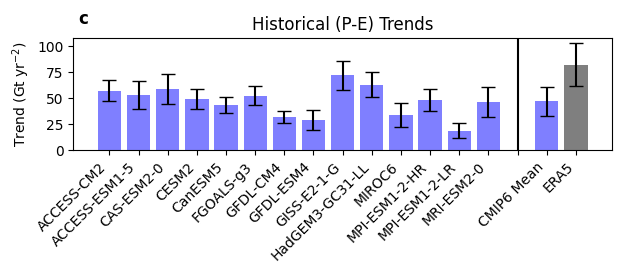

In [66]:
# Plot Fig. 2c 

model_list = list(PE_CMIP_timeseries.keys())
# Extract titles
titles = [model.split('.')[0] for model in model_list]


# Alphabetize slopes_CMIP6 and std_errs_CMIP6 based on sorted titles
sorted_indices = sorted(range(len(titles)), key=lambda i: titles[i])
slopes_CMIP6_sorted = [slopes_CMIP6[i] for i in sorted_indices]
std_errs_CMIP6_sorted = [std_errs_CMIP6[i] for i in sorted_indices]
titles_sorted = [titles[i] for i in sorted_indices]

# Adjusted positions for the bar plots to add spacing
x_positions = list(range(len(slopes_CMIP6_sorted)))
gap_position = len(slopes_CMIP6_sorted)  # Add a gap
new_positions = [gap_position + 1, gap_position + 2]  # Shift new bars to the right

# Create the barplot
plt.figure(figsize=(6.32, 3.16))
plt.bar(
    x_positions,
    slopes_CMIP6_sorted,
    color="blue",
    yerr=std_errs_CMIP6_sorted,
    capsize=5,
    alpha=0.5,
    label="CMIP6 Models",
)

# Add new barplots for CMIP mean and ERA5
plt.bar(
    new_positions[0],
    avg_slopes_CMIP6,
    color="blue",
    alpha=0.5,
    yerr=std_dev_slopes_CMIP6,
    capsize=5,
    label="CMIP Mean",
)
plt.bar(
    new_positions[1],
    slope_obs,
    color="black",
    alpha=0.5,
    yerr=std_err_obs,
    capsize=5,
    label="ERA5",
)

# Add vertical black line to separate groups
plt.axvline(x=gap_position, color="black", linewidth=1.5)

# Update x-axis with titles
all_titles = titles_sorted + ["", "CMIP6 Mean", "ERA5"]  # Add an empty title for the gap
plt.xticks(x_positions + [gap_position] + new_positions, all_titles, rotation=45, ha="right", fontsize=10)

# Add labels and titles
plt.ylabel(r"Trend (Gt yr$^{-2}$)")
plt.title(r"Historical (P-E) Trends")
plt.text(0.01, 1.25, "c", transform=plt.gca().transAxes, fontsize=12, fontweight="bold", va="top")
plt.yticks([0, 25, 50, 75, 100])

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
# To accompany F_(P-E), we will use the meltwater time series and associated uncertainty in Gt/yr 
# from Schmidt. et al. 2023 and Roach et al. 2023 

melt_timeseries = {
    1990: 115.8, 1991: 115.8, 1992: 115.8, 1993: 115.8, 1994: 115.8,
    1995: 110.2, 1996: 82.9, 1997: 154.4, 1998: 187.8, 1999: 499.9,
    2000: 428.1, 2001: 430.4, 2002: 276.9, 2003: 424.6, 2004: 488.2,
    2005: 453.6, 2006: 547.1, 2007: 679.5, 2008: 600.6, 2009: 534.7,
    2010: 585.4, 2011: 416.6, 2012: 443.8, 2013: 499.6, 2014: 456.9,
    2015: 381.3, 2016: 157.2, 2017: 331.8, 2018: 331.8, 2019: 331.8,
    2020: 331.8, 2021: 331.8
}
melt_timeseries = np.array([melt_timeseries[year] for year in range(1990, 2022)])
cumulative_melt = np.cumsum(melt_timeseries)

sigma_melt = 79 

# Finally, we want to convert the F_PE slope into a time series of its own 

years = np.linspace(1990, 2021, 32)
F_PE_timeseries = F_PE*(years-years[0])
error_F_PE_timeseries = error_F_PE*(years-years[0])
cumulative_F_PE = np.cumsum(F_PE_timeseries)

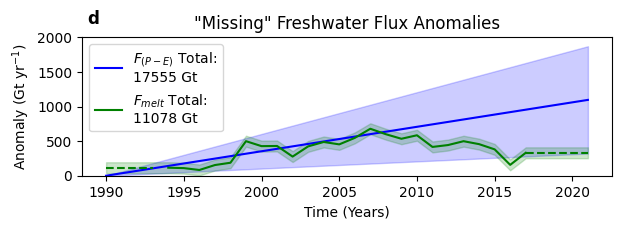

In [67]:
# Plot Fig. 2d 

# Initialize the figure with specific dimensions
plt.figure(figsize=(6.32, 2.5))

# Plot the curves
plt.plot(years, F_PE_timeseries,\
         label=f'$F_{{(P-E)}}$ Total:\n{cumulative_F_PE[-1]:.0f} Gt', color='blue')
plt.fill_between(years,(F_PE_timeseries-error_F_PE_timeseries),(F_PE_timeseries+error_F_PE_timeseries),\
                 color='blue', alpha=0.2)

plt.plot(years[4:28], melt_timeseries[4:28],\
         label=f'$F_{{melt}}$ Total:\n{cumulative_melt[-1]:.0f} Gt', color='g')
plt.plot(years[0:4], melt_timeseries[0:4],\
         linestyle='dashed', color='g')
plt.plot(years[27:], melt_timeseries[27:],\
         linestyle='dashed', color='g')
plt.fill_between(years,melt_timeseries-sigma_melt,melt_timeseries+sigma_melt,\
                 color='green', alpha=0.2)

plt.xlabel('Time (Years)')
plt.ylabel(r'Anomaly (Gt yr$^{-1}$)')
plt.title('"Missing" Freshwater Flux Anomalies')
plt.text(0.01, 1.2, 'd', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', va='top')


# Improve y-axis ticks
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.AutoLocator())

# Place the legend outside the plot
plt.legend(loc='upper left')
plt.ylim(0,2000)
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()